In [23]:
import numpy as np
import torch.nn.functional as F
from transform_factory import center_crop_224
from torchvision import transforms
import torch
from tqdm import tqdm
from captum.attr import visualization as viz
import os
from PIL import Image
from transform_factory import tensorize, resize_322

In [24]:
# config
seed = 0

In [74]:
with open(f"./val_seed_{seed}.npy", "rb") as f:
    filepath_list = np.load(f)

img_path = filepath_list[70]
img_name = os.path.basename(img_path)

orig_img = Image.open(img_path)
orig_img = tensorize(center_crop_224(resize_322(orig_img))).detach().numpy()

In [81]:
with open(f"results/val_seed_{seed}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_LayerIG_sample_2000_sigma_0.05_seed_{seed}_orig_true_config.npy", "rb") as f:
    orig_expl = np.load(f, allow_pickle=True)
    true_expls = np.load(f, allow_pickle=True)
    configs = np.load(f, allow_pickle=True)

print(np.mean(orig_expl), np.max(orig_expl), np.min(orig_expl))
print(orig_expl.shape, true_expls.shape, configs.shape)
orig_expl = F.interpolate(torch.tensor(orig_expl).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).numpy()
print(orig_expl.shape, orig_expl)



0.052705484647412815 0.28822632058490316 -0.028904264801839802
(1, 11, 11) (2000, 1, 11, 11) (2000,)
(1, 224, 224) [[[-0.00434554 -0.00434554 -0.00434554 ... -0.00152254 -0.00152254
   -0.00152254]
  [-0.00434554 -0.00434554 -0.00434554 ... -0.00152254 -0.00152254
   -0.00152254]
  [-0.00434554 -0.00434554 -0.00434554 ... -0.00152254 -0.00152254
   -0.00152254]
  ...
  [ 0.00156929  0.00156929  0.00156929 ... -0.00322282 -0.00322282
   -0.00322282]
  [ 0.00156929  0.00156929  0.00156929 ... -0.00322282 -0.00322282
   -0.00322282]
  [ 0.00156929  0.00156929  0.00156929 ... -0.00322282 -0.00322282
   -0.00322282]]]


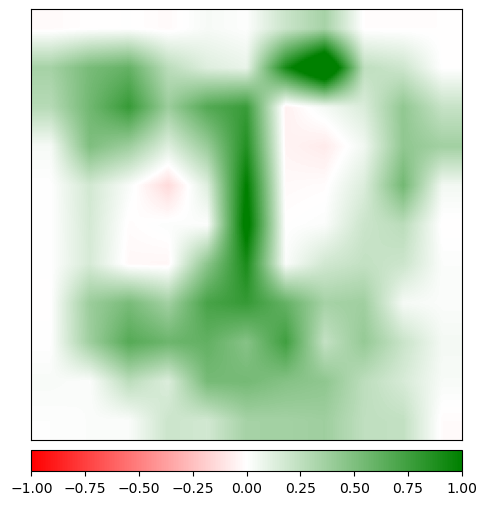

In [78]:
_ = viz.visualize_image_attr(np.transpose(orig_expl, (1,2,0)), np.transpose(orig_img, (1,2,0)), sign='all', method = 'heat_map', show_colorbar=True)

In [2]:
indicies = np.arange(0, 2000, 1)
np.random.shuffle(indicies)

cal_idx, val_idx = indicies[:1000], indicies[1000:]

scores = []

for true_expl, config in tqdm(zip(true_expls[cal_idx], configs[cal_idx])):

    T_inv_spatial = transforms.Compose([
        transforms.RandomRotation((-config['rot_angle'], -config['rot_angle'])),
        transforms.RandomVerticalFlip(config['flip_vertical']),
        transforms.RandomHorizontalFlip(config['flip_horizon']),
        
    ])
    
    true_expl = center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expl).unsqueeze(0), (322, 322), mode='bilinear'))).squeeze(0).numpy()

    # pp_true_expls.append(true_expl)
    scores.append(np.abs(true_expl - orig_expl))


scores = np.stack(scores)
print(scores.shape)
    

NameError: name 'true_expls' is not defined

In [5]:
test_expls =[]
for true_expl, config in tqdm(zip(true_expls[val_idx], configs[val_idx])):

    T_inv_spatial = transforms.Compose([
        transforms.RandomRotation((-config['rot_angle'], -config['rot_angle'])),
        transforms.RandomVerticalFlip(config['flip_vertical']),
        transforms.RandomHorizontalFlip(config['flip_horizon']),
        
    ])
    
    test_expls.append(center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expl).unsqueeze(0), (322, 322), mode='bilinear'))).squeeze(0).numpy())

test_expls = np.stack(test_expls)



1000it [00:52, 19.07it/s]


In [6]:
def qhat(score, alpha:float):
    n = score.shape[0]
    q_hat = np.quantile(score, np.ceil((n+1) * (1-alpha)) / n, axis = 0)

    return q_hat

def get_conf_interval(expl: np.ndarray, q_hat: np.ndarray):
    high = expl + q_hat
    low = expl - q_hat
    return (low, high)

def calc_coverage_prob(true: np.ndarray, conf_low: np.ndarray, conf_high: np.ndarray):
    is_cover = np.logical_and(conf_low <= true, true <= conf_high)
    coverage_prob = np.sum(is_cover, axis = 0) / true.shape[0]

    return coverage_prob

In [9]:
results = []

for alpha in np.arange(0.05, 1, 0.05):
    q_hat = qhat(scores, alpha)

    conf_low, conf_high = get_conf_interval(orig_expl, q_hat)
    
    coverage_prob = calc_coverage_prob(test_expls, conf_low, conf_high)

    zc_rate = zero_contain_rate(conf_high, conf_low)

    # print(np.mean(coverage_prob))
    results.append({
        'img': img,
        'expl_method': expl_method,
        'alpha': alpha,
        'coverage_prob': coverage_prob,
        'zero_contain_rate': zc_rate,
        'conf_high': conf_high,
        'conf_low': conf_low
    })



(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


KeyboardInterrupt: 